# Test Vessel-Quantification

## Set-up

Images are:

- RGB colored
- 2D (no z-dim)
- vessel network not clearly visible everywhere (low contrast)
- lighting is variable 

Code was generated with use of Microsoft Copilot + ChatGPT.
Conversation under: *Coding Assistent >
Prepare 2D picutres for Vessel-metrics*

## Import modules

In [ ]:
# Import modules
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# Import scikit-image functions
from skimage.filters import frangi, threshold_otsu
from skimage.morphology import disk, opening, remove_small_objects, remove_small_holes, skeletonize
#from skimage.morphology import remove_small_objects, remove_small_holes, skeletonize

In [ ]:
from skimage import io, exposure
from skimage.restoration import rolling_ball
from scipy.ndimage import distance_transform_edt

plt.rcParams["figure.figsize"] = (6,6)

## Image preparation

Before vessel quantification, the image is treated to enhance the vessels and remove some noise already.

In [2]:
# Load image
data_path = "./data/"
image_list = os.listdir(data_path)
img_file = image_list[0]
print(f"Processing image: {img_file}")

Processing image: img2512221726-1.tif


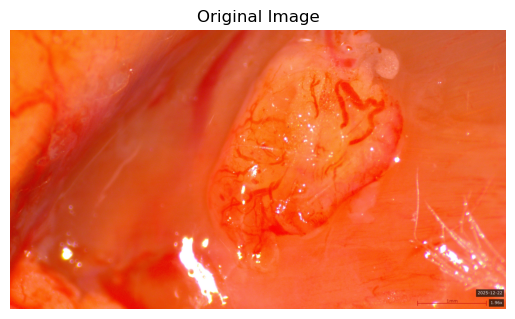

In [18]:
img_path = os.path.join(data_path, img_file)
img = tiff.imread(img_path)

# Display the original image in grayscale
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [19]:
# Convert to grayscale float32
img_gray = (
    0.299 * img[..., 0] +
    0.587 * img[..., 1] +
    0.114 * img[..., 2]
).astype(np.float32)

# Normalize to 0–255 and cast to uint8
img_norm = img_gray - img_gray.min()
if img_norm.max() > 0:
    img_norm = img_norm / img_norm.max()
img_u8 = (img_norm * 255).astype(np.uint8)

# Optional blur
img_blur = cv2.GaussianBlur(img_u8, (5, 5), 0)

# Contrast enhancement
img_eq_u8 = cv2.equalizeHist(img_blur)

# Convert to float32 in range [0, 1]
img_eq_float = img_eq_u8.astype(np.float32) / 255.0


print("Final image dtype:", img_eq_float.dtype, "shape:", img_eq_float.shape)

Final image dtype: float32 shape: (2160, 3840)


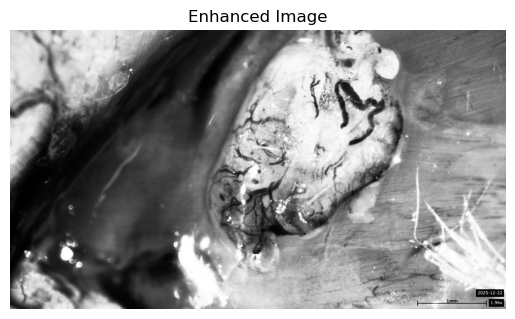

In [21]:
# Display the enhanced image in grayscale
plt.imshow(img_eq_float, cmap='gray')
plt.title("Enhanced Image")
plt.axis('off')
plt.show()

From here, the vessels are clearly made visible in a darker way.
2 functions were used:
- `cv2.GaussianBlur()` 
- `cv2.equalizeHist()` 

`cv2.GaussianBlur()`: **Gaussian blur** (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise and reduce definition.

`cv2.equalizeHist()`: **Histogram Equalization (HE)** is a technique used to improve image contrast by redistributing pixel intensity values across the entire range. It is especially effective in images where the foreground and background have similar brightness, making it hard to distinguish details. By enhancing areas with low contrast, it makes hidden features more visible, showing finer details in both dark and bright regions.

## Scikit-image analysis for vessel quantification

**Scikit-image** is a collection of algorithms for image processing. This pipeline makes use of:
- `skimage.filters`
- `skimage.morphology`

Read the documentation on both [filters](https://scikit-image.org/docs/stable/api/skimage.filters.html) and [morphology](https://scikit-image.org/docs/0.25.x/api/skimage.morphology.html) by clicking the links.

### Write the functions

In [32]:
# Enhance dark structures (vessels) using contrast normalization and inversion
def enhance_dark_vessels(img, sigmas=(1,2,3,4,5)):
    inverted = 1 - img
    vesselness = frangi(inverted, sigmas=sigmas)
    vesselness = (vesselness - vesselness.min()) / (vesselness.max() - vesselness.min())
    return vesselness

### Run the pipeline

In [33]:
vesselness = enhance_dark_vessels(img_eq_float, sigmas=(1,2,3,4,5))

### Visualize result

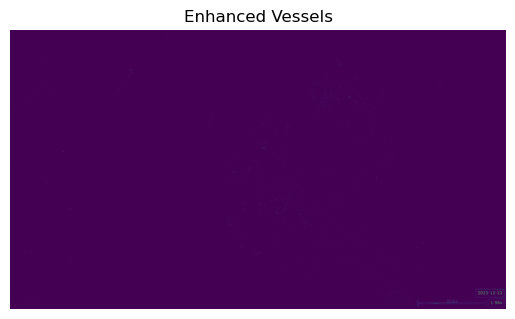

In [35]:
plt.imshow(vesselness)
plt.title("Enhanced Vessels")
plt.axis('off')
plt.show()